### Finding $\phi_p$ and $\hat{p}$ and compare the drag computed to the full expression

In [23]:
""" PROCESSING: A new sampling function 
    Fixed distance from the surface instead of wave following coordinate. """
from scipy import interpolate
def sampling(array_simu, case, hsample, eta):
    """ This function is similar to array_newcoord, but instead of mapping 2D, it only samples one line at 
        a given height hsample (in cartesian coordinate away from the surface.
        Args:
            array_simu: simulation output 2D array to sample.
            case: case object for metadata like h, ak and k. 
        Returns:
            array_interp: 1D interpolated field (N*1).
            z_interp: 1D interpolate position (N*1). """
    h = case.h; L0=case.L0; N = case.N
    xarray = np.linspace(-np.pi, np.pi, N)
    array_interp = np.zeros(np.shape(array_simu[-1]))
    z_interp = np.zeros(np.shape(array_simu)[-1])
    # Do 1d interpolation for each x
    for i in range(np.shape(array_simu)[0]):
        xi = xarray[i]
        # Grid in simulation, translated vertically to have the resting interface at z=0
        z_simu = np.linspace(0,L0,N,endpoint=False) + L0/2/N - h 
        f = interpolate.interp1d(z_simu, array_simu[i,:], fill_value="extrapolate")
        # Explicitly computed corresponding z, using a0cos(kxi)
        z_grid = eta[i] + hsample
        array_grid = f(z_grid)
        array_interp[i] = array_grid
        z_interp[i] = z_grid
    return (array_interp, z_interp)

In [21]:
""" PROCESSING: find phase shift and amplitude (assuming sinusoidal). """
from coordinate import array_newcoord
from scipy import signal
from scipy.signal import savgol_filter
from scipy.signal import argrelextrema

def find_dphase1 (p2D, eta, case):
    """ This one finds the phase difference by looking at the maximum, which requires the pressure to be averaged and smoothed first.
        Args:
            p2D: one 2D pressure array 
            eta: because the array_newcoord needs some metadata
            case: because we need some metadata
        Returns:
            dphase: 4*1 array (for 4 peaks)
            amp: 4*1 array
    """               
    """ Coordinate transform the average p """
    p2D_interp, zgrid = array_newcoord(p2D, case=case, eta=eta)
    """ Find local maximum. Filter out the secondary peaks by requiring a positive p. """    
    p2D_hat = savgol_filter(p2D_interp[:,85], 81, 4)
    a_prime = np.array(argrelextrema(p2D_hat, np.greater)[0])
    a = []
    for idx in a_prime:
        if p2D_hat[idx] > 0:
            a.append(idx)
    a = np.array(a)
    b = np.array([128,256,384,512]) # Assuming already know where the eta peaks are
    if len(a) == len(b):
        dphase = b - a
        print(dphase)
    else: 
        print('Did not find 4 peaks!')
        print(a)
    """ But still uses the closest layer peaks for amplitude """
#     pamp = p2D_hat[a] 
    """ Define as (high - low)/2 instead """
    pamp = 0.5*(p2D_hat[a] - p2D_hat.min())
    pamp = np.array(pamp) 
    return (dphase, pamp)

def find_dphase2 (p2D, eta, case):
    """ Different ways of finding dphase1. Based on the cross-spectral relation. Should be robust even for noisy data. 
        Args:
            p2D: one 2D pressure array 
            eta: because the array_newcoord needs some metadata
            case: because we need some metadata
    """
    p2D_sample, zsample = sampling(p2D, case=case, hsample=0.02*2*np.pi/case.k, eta=eta)
    p2D_interp, zgrid = array_newcoord(p2D, case=case, eta=eta)
    f1, Pxy1 = signal.csd(eta, p2D_interp[:,85]-np.average(p2D_interp[:,85]), fs=512, nperseg=512, window='hanning')
    f2, Pxy2 = signal.csd(eta, p2D_interp[:,90]-np.average(p2D_interp[:,90]), fs=512, nperseg=512, window='hanning')
    f3, Pxy3 = signal.csd(eta, p2D_sample-np.average(p2D_sample), fs=512, nperseg=512, window='hanning', scaling='spectrum') 
    phase = np.array((np.angle(Pxy1)[4]/2/np.pi*360, np.angle(Pxy2)[4]/2/np.pi*360, np.angle(Pxy3)[4]/2/np.pi*360))
    cospectrum = np.array((Pxy1[4].imag, Pxy2[4].imag, Pxy3[4].imag))
    cospectrum_full = np.array((np.sum(Pxy1.imag), np.sum(Pxy2.imag), np.sum(Pxy3.imag)))
    return (phase,cospectrum,cospectrum_full)

def find_dphase3 (p2D, eta, case):
    p2D_sample, zsample = sampling(p2D, case=case, hsample=0.02*2*np.pi/case.k, eta=eta)
    p2D_interp, zgrid = array_newcoord(p2D, case=case, eta=eta)
    spectrum1 = np.fft.fft(p2D_interp[:,88]-np.average(p2D_interp[:,88]))
    spectrum2 = np.fft.fft(p2D_interp[:,90]-np.average(p2D_interp[:,90]))
    spectrum3 = np.fft.fft(p2D_sample-np.average(p2D_sample))     
    phase = np.array((np.angle(spectrum1)[4]/2/np.pi*360, np.angle(spectrum2)[4]/2/np.pi*360, np.angle(spectrum3)[4]/2/np.pi*360))
    amplitude = np.array((np.abs(spectrum1)[4], np.abs(spectrum2)[4], np.abs(spectrum3)[4]))*2/512
    return phase, amplitude

# for case in (case1,case2,case3,case7,case8,case4,case5,case6,case7,case8,case9,case10,case11,case12,case13,case14,case15,case16):
#     case.tau0 = case.rho2*case.ustar**2
#     print('ak=%g, c/u_*=%.0f' %(case.ak, case.wave.c/case.ustar))
#     p2D_aver = np.average(case.p_2D, axis=0)
#     eta = np.roll(np.average(case.phase['eta'][-1], axis=0), -case.phase['idx'][-1], axis=0) - 1 # Last frame of eta
#     case.dphase, case.pamp, case.dphase1, case.pamp1 = find_dphase(p2D_aver, eta, case)
#     print(case.pamp/case.tau0)

# for case in (case1,case2,case3,case7,case8,case4,case5,case6,case7,case8,case9,case10,case11,case12,case13,case14,case15,case16):
#     case.tau0 = case.rho2*case.ustar**2
#     print('ak=%g, c/u_*=%.0f' %(case.ak, case.wave.c/case.ustar))
#     p2D_aver = np.average(case.p_2D, axis=0)
#     eta = np.roll(np.average(case.phase['eta'][-1], axis=0), -case.phase['idx'][-1], axis=0) - 1 # Last frame of eta
#     case.dphase, case.pamp = find_dphase1 (p2D_aver, eta, case)
#     print(case.pamp/case.tau0)
#     case.dphase_new = np.zeros([3,len(case.p_2D)])
#     for tindex in range(0,len(case.p_2D)):
#         eta = np.roll(np.average(case.phase['eta'][tindex], axis=0), -case.phase['idx'][tindex], axis=0) - 1
#         case.dphase_new[:,tindex], cospectrum = find_dphase2 (case.p_2D[tindex], eta, case)   

In [ ]:
""" CHECK """
case = case9
p2D_aver = np.average(case.p_2D, axis=0)
case.dphase, case.pamp = find_dphase1 (p2D_aver, eta, case)
print(case.pamp/case.tau0)
case.dphase_fourier, case.cospectrum_fourier, case.cospectrum_full = find_dphase2 (p2D_aver, eta, case)
print('%.1f, %.1f, %.1f, %.1f' %(case.dphase_fourier[0], case.dphase_fourier[1], case.dphase_fourier[2], np.average(case.dphase)/128*360))
case.dphase_spec, case.pamp_spec = find_dphase3 (p2D_aver, eta, case)
print('%.1f, %.1f, %.1f, %.1f, %.1f, %.1f' %(case.dphase_spec[0], case.dphase_spec[1], case.dphase_spec[1], (case.pamp_spec[0]/case.tau0), (case.pamp_spec[1]/case.tau0), (case.pamp_spec[1]/case.tau0)))

In [24]:
# """ Original way of finding phase """
# # for case in (case1,case2,case3,case7,case8,case4,case5,case6,case7,case8,case9,case10,case11,case12,case13,case14,case15,case16,case_con1,case_con2,case_con3):
# for case in (case1,case2,case3,case7,case8,case4,case5,case6,case7,case8,case9,case10,case11,case12,case13,case14,case15,case16,case17,case18):
#     case.tau0 = case.rho2*case.ustar**2
#     print('ak=%g, c/u_*=%.0f' %(case.ak, case.wave.c/case.ustar))
#     p2D_aver = np.average(case.p_2D, axis=0)
#     eta = np.roll(np.average(case.phase['eta'][-1], axis=0), -case.phase['idx'][-1], axis=0) - 1 # Last frame of eta
#     case.dphase, case.pamp = find_dphase1(p2D_aver, eta, case)
#     print(case.pamp/case.tau0)

# """ New way of finding phase. Cross spectral analysis. """
# # for case in (case1,case2,case3,case4,case5,case6,case7,case8,case9,case10,case11,case12,case13,case14,case15,case16,case_con1,case_con2,case_con3):
# for case in (case1,case2,case3,case4,case5,case6,case7,case8,case9,case10,case11,case12,case13,case14,case15,case16,case17,case18):
#     case.tau0 = case.rho2*case.ustar**2
#     print('ak=%g, c/u_*=%.0f' %(case.ak, case.wave.c/case.ustar))
#     p2D_aver = np.average(case.p_2D, axis=0)
#     eta = np.roll(np.average(case.phase['eta'][-1], axis=0), -case.phase['idx'][-1], axis=0) - 1 # Last frame of eta
#     case.dphase_fourier, case.cospectrum_fourier, case.cospectrum_full = find_dphase2 (p2D_aver, eta, case)
#     print('%.1f, %.1f, %.1f, %.1f' %(case.dphase_fourier[0], case.dphase_fourier[1], case.dphase_fourier[2], np.average(case.dphase)/128*360))

""" Yet another way of finding phase AND amplitude. Simple Fourier transform. 
    With special treatment for strong forcing cases. 
    How Fp_aver is computed has to correspond with the pressure
"""

# Strong forcing, limit the first window
for case in (case7,case14):
    case.tau0 = case.rho2*case.ustar**2
    print('ak=%g, c/u_*=%.0f' %(case.ak, case.wave.c/case.ustar))
    case.tp1 = case.p['t'][5]; case.tp2 = case.p['t'][15]
    case.Fp_aver = np.average(case.Fp[5:15])
    p2D_aver = np.average(case.p['p_2D'][5:15], axis=0)
    etai = np.where(np.isclose(case.phase['t'], case.p['t'][15]))[0][0]
    eta = np.roll(np.average(case.phase['eta'][etai], axis=0), -case.phase['idx'][etai], axis=0) - 1
    case.dphase_spec, case.pamp_spec = find_dphase3 (p2D_aver, eta, case)
    print('%.1f, %.1f, %.1f, %.1f, %.1f, %.1f' %(case.dphase_spec[0], case.dphase_spec[1], case.dphase_spec[1], (case.pamp_spec[0]/case.tau0), (case.pamp_spec[1]/case.tau0), (case.pamp_spec[1]/case.tau0)))
for case in (case1,case2,case4):
    case.tau0 = case.rho2*case.ustar**2
    print('ak=%g, c/u_*=%.0f' %(case.ak, case.wave.c/case.ustar))
    case.tp1 = case.p['t'][5]; case.tp2 = case.p['t'][20]
    case.Fp_aver = np.average(case.Fp[5:20])
    p2D_aver = np.average(case.p['p_2D'][5:20], axis=0)
    etai = np.where(np.isclose(case.phase['t'], case.p['t'][20]))[0][0]
    eta = np.roll(np.average(case.phase['eta'][etai], axis=0), -case.phase['idx'][etai], axis=0) - 1
    case.dphase_spec, case.pamp_spec = find_dphase3 (p2D_aver, eta, case)
    print('%.1f, %.1f, %.1f, %.1f, %.1f, %.1f' %(case.dphase_spec[0], case.dphase_spec[1], case.dphase_spec[1], (case.pamp_spec[0]/case.tau0), (case.pamp_spec[1]/case.tau0), (case.pamp_spec[1]/case.tau0)))
for case in (case15,case16,case18,case19):
    case.tau0 = case.rho2*case.ustar**2
    print('ak=%g, c/u_*=%.0f' %(case.ak, case.wave.c/case.ustar))
    istart = int(len(case.p['t'])*0.1)
    case.tp1 = case.p['t'][istart]; case.tp2 = case.p['t'][-1]
    case.Fp_aver = np.average(case.Fp[istart:])
    p2D_aver = np.average(case.p['p_2D'][istart:], axis=0)
    eta = np.roll(np.average(case.phase['eta'][-1], axis=0), -case.phase['idx'][-1], axis=0) - 1 # Last frame of eta
    case.dphase_spec, case.pamp_spec = find_dphase3 (p2D_aver, eta, case)
    print('%.1f, %.1f, %.1f, %.1f, %.1f, %.1f' %(case.dphase_spec[0], case.dphase_spec[1], case.dphase_spec[1], (case.pamp_spec[0]/case.tau0), (case.pamp_spec[1]/case.tau0), (case.pamp_spec[1]/case.tau0)))
for case in (case3,case4,case5,case8,case9,case10,case12,case13):
    case.tau0 = case.rho2*case.ustar**2
    print('ak=%g, c/u_*=%.0f' %(case.ak, case.wave.c/case.ustar))
    case.tp1 = case.p['t'][5]; case.tp2 = case.p['t'][-1]
    case.Fp_aver = np.average(case.Fp[5:])
    p2D_aver = np.average(case.p['p_2D'][5:], axis=0)
    eta = np.roll(np.average(case.phase['eta'][-1], axis=0), -case.phase['idx'][-1], axis=0) - 1 # Last frame of eta
    case.dphase_spec, case.pamp_spec = find_dphase3 (p2D_aver, eta, case)
    print('%.1f, %.1f, %.1f, %.1f, %.1f, %.1f' %(case.dphase_spec[0], case.dphase_spec[1], case.dphase_spec[1], (case.pamp_spec[0]/case.tau0), (case.pamp_spec[1]/case.tau0), (case.pamp_spec[1]/case.tau0)))
# Too few times:
for case in (case11,case6,case17):
    case.tau0 = case.rho2*case.ustar**2
    print('ak=%g, c/u_*=%.0f' %(case.ak, case.wave.c/case.ustar))
    case.tp1 = case.p['t'][2]; case.tp2 = case.p['t'][-1]
    case.Fp_aver = np.average(case.Fp[2:])
    p2D_aver = np.average(case.p['p_2D'][2:], axis=0)
    eta = np.roll(np.average(case.phase['eta'][-1], axis=0), -case.phase['idx'][-1], axis=0) - 1 # Last frame of eta
    case.dphase_spec, case.pamp_spec = find_dphase3 (p2D_aver, eta, case)
    print('%.1f, %.1f, %.1f, %.1f, %.1f, %.1f' %(case.dphase_spec[0], case.dphase_spec[1], case.dphase_spec[1], (case.pamp_spec[0]/case.tau0), (case.pamp_spec[1]/case.tau0), (case.pamp_spec[1]/case.tau0)))

ak=0.15, c/u_*=2
95.5, 96.6, 96.6, 3.4, 3.1, 3.1
ak=0.25, c/u_*=2
68.4, 68.2, 68.2, 4.2, 3.9, 3.9
ak=0.2, c/u_*=2
72.5, 72.0, 72.0, 3.4, 3.1, 3.1
ak=0.2, c/u_*=4
44.0, 42.0, 42.0, 5.6, 5.3, 5.3
ak=0.1, c/u_*=2
88.9, 89.4, 89.4, 1.5, 1.4, 1.4
ak=0.25, c/u_*=4
43.4, 41.5, 41.5, 6.4, 6.1, 6.1
ak=0.25, c/u_*=8
102.7, 100.5, 100.5, 3.5, 3.4, 3.4
ak=0.25, c/u_*=6
55.3, 53.5, 53.5, 6.6, 6.6, 6.6
ak=0.2, c/u_*=6
63.4, 61.3, 61.3, 5.3, 5.2, 5.2
ak=0.2, c/u_*=8
104.0, 101.1, 101.1, 3.0, 2.9, 2.9
ak=0.1, c/u_*=2
89.1, 89.5, 89.5, 1.6, 1.5, 1.5
ak=0.1, c/u_*=4
38.2, 37.4, 37.4, 3.4, 3.3, 3.3
ak=0.15, c/u_*=3
55.6, 55.7, 55.7, 3.9, 3.6, 3.6
ak=0.15, c/u_*=4
46.0, 45.3, 45.3, 5.5, 5.2, 5.2
ak=0.15, c/u_*=6
58.8, 57.7, 57.7, 6.4, 6.2, 6.2
ak=0.15, c/u_*=12
147.0, 140.8, 140.8, 1.5, 1.3, 1.3
ak=0.15, c/u_*=16
-174.0, -172.8, -172.8, 3.6, 2.5, 2.5
ak=0.15, c/u_*=8
88.6, 87.5, 87.5, 4.6, 4.4, 4.4
ak=0.1, c/u_*=8
105.6, 104.4, 104.4, 2.0, 1.9, 1.9
ak=0.1, c/u_*=6
73.5, 72.4, 72.4, 3.3, 3.1, 3.1


In [24]:
""" Read in amplitude of Kihara as an array in z. In multiples of pi. """
import pandas as pd
Kihara_phi = pd.read_csv('otherdata/extracted_data/Kihara_phi.csv', names=['z_CU0','phi_CU0','z_CU2','phi_CU2','z_CU4','phi_CU4','z_CU8','phi_CU8','z_CU12','phi_CU12','z_CU16','phi_CU16'], 
                         delimiter=',', skiprows=2)
# Kihara_phi = Kihara_phi.sort_values(by='y1', ascending=True)
# print(Kihara_phi)

Kihara_pamp = pd.read_csv('otherdata/extracted_data/Kihara_pamp.csv', names=['z_CU0','pamp_CU0','z_CU2','pamp_CU2','z_CU4','pamp_CU4','z_CU8','pamp_CU8','z_CU12','pamp_CU12','z_CU16','pamp_CU16'], 
                         delimiter=',', skiprows=2)
# Kihara_pamp = Kihara_phi.sort_values(by='y1', ascending=True)
# print(Kihara_phi)

In [25]:
Kihara_CU = np.array((0,2,4,8))
Kihara_phi0 = np.array((Kihara_phi.phi_CU0[0],Kihara_phi.phi_CU2[1],Kihara_phi.phi_CU4[0],Kihara_phi.phi_CU8[0]))*180 # The first point of CU2 is for some reason not righ
Kihara_pamp0 = np.array((Kihara_pamp.pamp_CU0[0],Kihara_pamp.pamp_CU2[0],Kihara_pamp.pamp_CU4[0],Kihara_pamp.pamp_CU8[0])) # The first point of CU2 is for some reason not right


0.25 2.004993765576342 82
0.25 4.009987531152684 67
0.25 6.014981296729027 10
0.25 8.019975062305368 52
0.2 2.004993765576342 55
0.2 4.009987531152684 43
0.2 8.019975062305368 15
0.2 6.014981296729027 55
0.15 2.004993765576342 40
0.15 4.009987531152684 34
0.15 3.0074906483645134 45
0.15 6.014981296729027 75
0.15 8.019975062305368 12
0.1 2.004993765576342 38
0.1 4.009987531152684 40
0.1 6.014981296729027 13
0.1 8.019975062305368 13


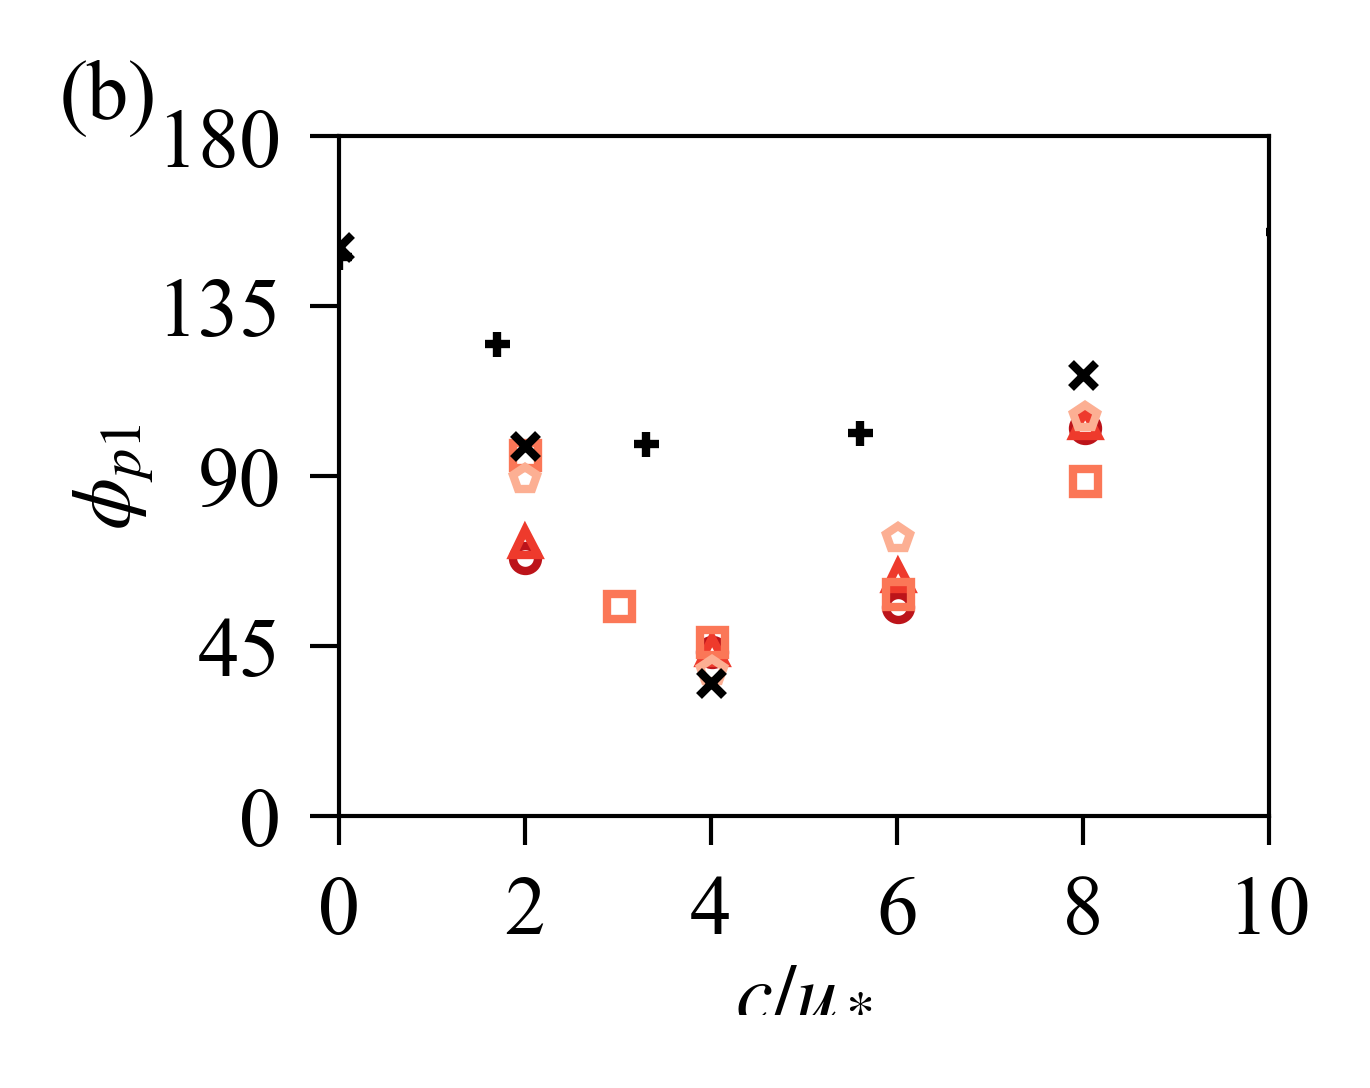

In [38]:
""" FIGURE: put all the phase shift together """
fig = plt.figure(figsize=[2,1.5]); ax = plt.gca()

plt.ylabel(r'$\phi_{p1}$',labelpad=0)
plt.xlabel(r'$c/u_*$', labelpad=0)

# for case in (case1,case2,case3):
#     p1, = ax.plot(case.wave.c/case.ustar, np.average(case.dphase)/128*360, marker='o', mfc='none',
#              label=r'$c/u_*=%.0f$, ak=%g' %(case.wave.c/case.ustar, case.ak), lw=0, markersize=3, color=cmap(39), alpha = 1)
# for case in (case7,case9,case8,case10,case11):
#     p3, = ax.plot(case.wave.c/case.ustar, np.average(case.dphase)/128*360, marker='s', mfc='none',
#              label=r'$c/u_*=%.0f$, ak=%g' %(case.wave.c/case.ustar, case.ak), lw=0, markersize=3, color=cmap(37), alpha = 1)
# for case in (case4,case5,case6):
#     p5, = ax.plot(case.wave.c/case.ustar, np.average(case.dphase)/128*360, marker='x', mfc='none',
#              label=r'$c/u_*=%.0f$, ak=%g' %(case.wave.c/case.ustar, case.ak), lw=0, markersize=3, color=cmap(34), alpha = 1)

for case in (case14,case15,case18,case16):
    print(case.ak, case.wave.c/case.ustar, len(case.p['p_2D']))
    p0, = ax.plot(case.wave.c/case.ustar, case.dphase_spec[0], marker='o', mfc='none',
             label=r'$c/u_*=%.0f$, ak=%g' %(case.wave.c/case.ustar, case.ak), lw=0, markersize=3, color=cmap(39), alpha = 1)
for case in (case1,case2,case3,case19):
    print(case.ak, case.wave.c/case.ustar, len(case.p['p_2D']))
    p1, = ax.plot(case.wave.c/case.ustar, case.dphase_spec[0], marker='^', mfc='none',
             label=r'$c/u_*=%.0f$, ak=%g' %(case.wave.c/case.ustar, case.ak), lw=0, markersize=3, color=cmap(37), alpha = 1)
for case in (case7,case9,case8,case10,case11):
    print(case.ak, case.wave.c/case.ustar, len(case.p['p_2D']))
    p3, = ax.plot(case.wave.c/case.ustar, case.dphase_spec[0], marker='s', mfc='none',
             label=r'$c/u_*=%.0f$, ak=%g' %(case.wave.c/case.ustar, case.ak), lw=0, markersize=3, color=cmap(35), alpha = 1)
for case in (case4,case5,case17,case6):
    print(case.ak, case.wave.c/case.ustar, len(case.p['p_2D']))
    p5, = ax.plot(case.wave.c/case.ustar, case.dphase_spec[0], marker='p', mfc='none',
             label=r'$c/u_*=%.0f$, ak=%g' %(case.wave.c/case.ustar, case.ak), lw=0, markersize=3, color=cmap(33), alpha = 1)
    
p_Kihara, = ax.plot(Kihara_CU, Kihara_phi0, marker='x', mfc='none', lw=0, markersize=3, color='k')
Druzhini_CU = [0, 1.7, 3.3, 5.6, 10.1]
Druzhini_phi0 = np.array([0.8221, 0.6938, 0.5470, 0.5634, 0.8597])*180
p_Drunzhini, = ax.plot(Druzhini_CU, Druzhini_phi0, marker='+', mfc='none', lw=0, markersize=3, color='k')
# """ Plot sin(dphase) instead """
# plt.figure(figsize = [4,2]); ax = plt.gca()
# for case in (case1,case2,case3,case4,case5,case6,case7,case8,case9,case10,case11):
#     plt.plot(case.wave.c/case.ustar, np.sin(np.average(case.dphase)/128*2*np.pi), c=case.cc, marker=case.marker, mfc='none', lw=0, markersize=3, alpha = 1)
# plt.ylim([0, 1])
# plt.ylabel(r'$sin(\phi_p)$')
# plt.xlabel(r'$c/u_*$')
plt.ylim([0,180])
ax.yaxis.set_ticks(np.arange(0, 181, 45))
plt.xlim([0,10])
ax.set_xticks(np.arange(0,12,2))
ax.annotate('(b)', xy=(-0.3, 1), ha='left', va='bottom', xycoords='axes fraction')
# l = ax.legend([(p_Kihara)], [r'Kihara 2006'],
#                handler_map={tuple: HandlerTuple(ndivide=None)}, loc='upper left', fancybox=False, handlelength=1)

fig.savefig('review/dphase_modified.pdf', bbox_inches='tight')
fig.savefig('review/dphase.eps', bbox_inches='tight')

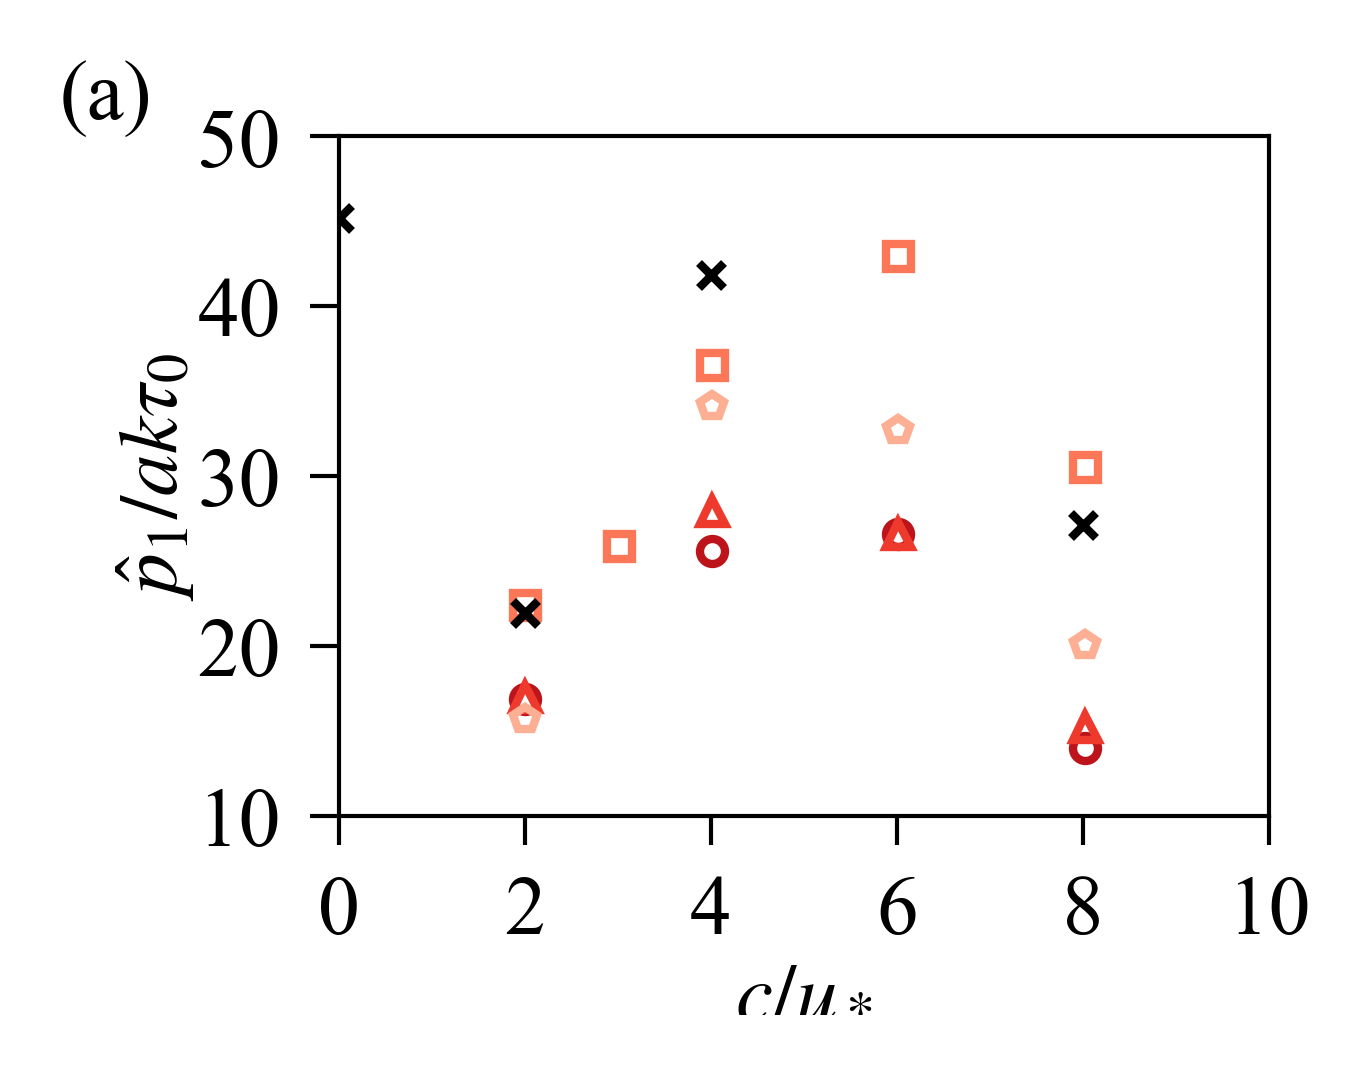

In [47]:
""" FIGURE_PRESENTATION: put all the amplitude together, divided by ak, to arrive at Um """
fig = plt.figure (figsize=[2,1.5]); ax1 = plt.gca()
# Manually set the position and relative size of the inset axes within ax1

for case in (case14,case15,case16,case18):
    p0, = ax1.plot(case.wave.c/case.ustar, (case.pamp_spec[0]/case.tau0/case.ak), marker='o', mfc='none', 
                  lw=0, markersize=3, color=cmap(39), alpha = 1)
for case in (case1,case2,case3,case19):
    p1, = ax1.plot(case.wave.c/case.ustar, (case.pamp_spec[0]/case.tau0/case.ak), marker='^', mfc='none', 
                   lw=0, markersize=3, color=cmap(37), alpha = 1)
for case in (case7,case9,case8,case10,case11):
    p3, = ax1.plot(case.wave.c/case.ustar, (case.pamp_spec[0]/case.tau0/case.ak), marker='s', mfc='none',
                   lw=0, markersize=3, color=cmap(35), alpha = 1)
for case in (case4,case5,case6,case17):
    p5, = ax1.plot(case.wave.c/case.ustar, (case.pamp_spec[0]/case.tau0/case.ak), marker='p', mfc='none',
                   lw=0, markersize=3, color=cmap(33), alpha = 1)
# l = ax1.legend([(p1),(p3),(p5)], [r'$ak=0.20$',r'$ak=0.15$',r'$ak=0.10$'],
#                handler_map={tuple: HandlerTuple(ndivide=None)}, loc='lower center', frameon=False)

p_Kihara, = ax1.plot(Kihara_CU, Kihara_pamp0, marker='x', mfc='none', lw=0, markersize=3, color='k')
""" Failed to make sense of the other data set """
# Druzhini_CU = np.array([0.01, 1.7, 3.3, 5.6, 10.1])
# Druzhini_c = np.array([0, 0.005, 0.1, 0.2, 0.3])
# Druzhini_ustar = Druzhini_c/Druzhini_CU
# Druzhini_ustar[0] = 0.0263
# print(Druzhini_ustar)
# Druzhini_pamp0 = np.array([0.654,0.384,0.328,0.243,0.154])/(0.0263**2)
# Druzhini_CU = [0, 1.7, 3.3, 5.6, 10.1]
# p_Druzhini, = ax1.plot(Druzhini_CU, Druzhini_pamp0, marker='+', mfc='none', lw=0, markersize=3, color='k')


plt.ylim([10,50])
plt.xlim([0,10])
ax1.set_ylabel(r'$\hat{p}_1/ ak \tau_0$', labelpad=0)
ax1.set_xlabel(r'$c/u_*$', labelpad=0)
ax1.set_xticks(np.arange(0,12,2))
ax1.annotate('(a)', xy=(-0.3, 1), ha='left', va='bottom', xycoords='axes fraction')
# fig.savefig('figures/phat.pdf', bbox_inches='tight', pad_inches=0.1)
fig.savefig('review/phat.pdf', bbox_inches='tight')
fig.savefig('review/phat.eps', bbox_inches='tight')

In [ ]:
fig = plt.figure (figsize=[2,1.5]); ax1 = plt.gca()
# Manually set the position and relative size of the inset axes within ax1

for case in (case14,case15,case16,case18):
    p0, = ax1.plot(case.wave.c/case.ustar, (np.average(case.pamp)/case.tau0/case.ak), marker='o', mfc='none', 
                  lw=0, markersize=3, color=cmap(39), alpha = 1)
for case in (case1,case2,case3):
    p1, = ax1.plot(case.wave.c/case.ustar, (np.average(case.pamp)/case.tau0/case.ak), marker='^', mfc='none', 
                   lw=0, markersize=3, color=cmap(37), alpha = 1)
for case in (case7,case9,case8,case10,case11):
    p3, = ax1.plot(case.wave.c/case.ustar, (np.average(case.pamp)/case.tau0/case.ak), marker='s', mfc='none',
                   lw=0, markersize=3, color=cmap(35), alpha = 1)
for case in (case4,case5,case6,case17):
    p5, = ax1.plot(case.wave.c/case.ustar, (np.average(case.pamp)/case.tau0/case.ak), marker='p', mfc='none',
                   lw=0, markersize=3, color=cmap(33), alpha = 1)
# l = ax1.legend([(p1),(p3),(p5)], [r'$ak=0.20$',r'$ak=0.15$',r'$ak=0.10$'],
#                handler_map={tuple: HandlerTuple(ndivide=None)}, loc='lower center', frameon=False)

plt.ylim([10,50])
plt.xlim([0,10])
ax1.set_ylabel(r'$\hat{p}/ ak \tau_0$', labelpad=0)
ax1.set_xlabel(r'$c/u_*$', labelpad=0)
ax1.set_xticks(np.arange(0,12,2))
ax1.annotate('(a)', xy=(-0.3, 1), ha='left', va='bottom', xycoords='axes fraction')
# fig.savefig('figures/phat.pdf', bbox_inches='tight', pad_inches=0.1)
fig.savefig('figures_jfm/phat.pdf', bbox_inches='tight')
fig.savefig('figures_jfm/phat.eps', bbox_inches='tight')

2.004993765576342 0.4860029003718144 0.4906826244637991
4.009987531152684 0.5292391447331458 0.549470368969385
6.014981296729027 0.6830001895182991 0.6824678205342599
8.019975062305368 0.4566731184369909 0.42632010234469014


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


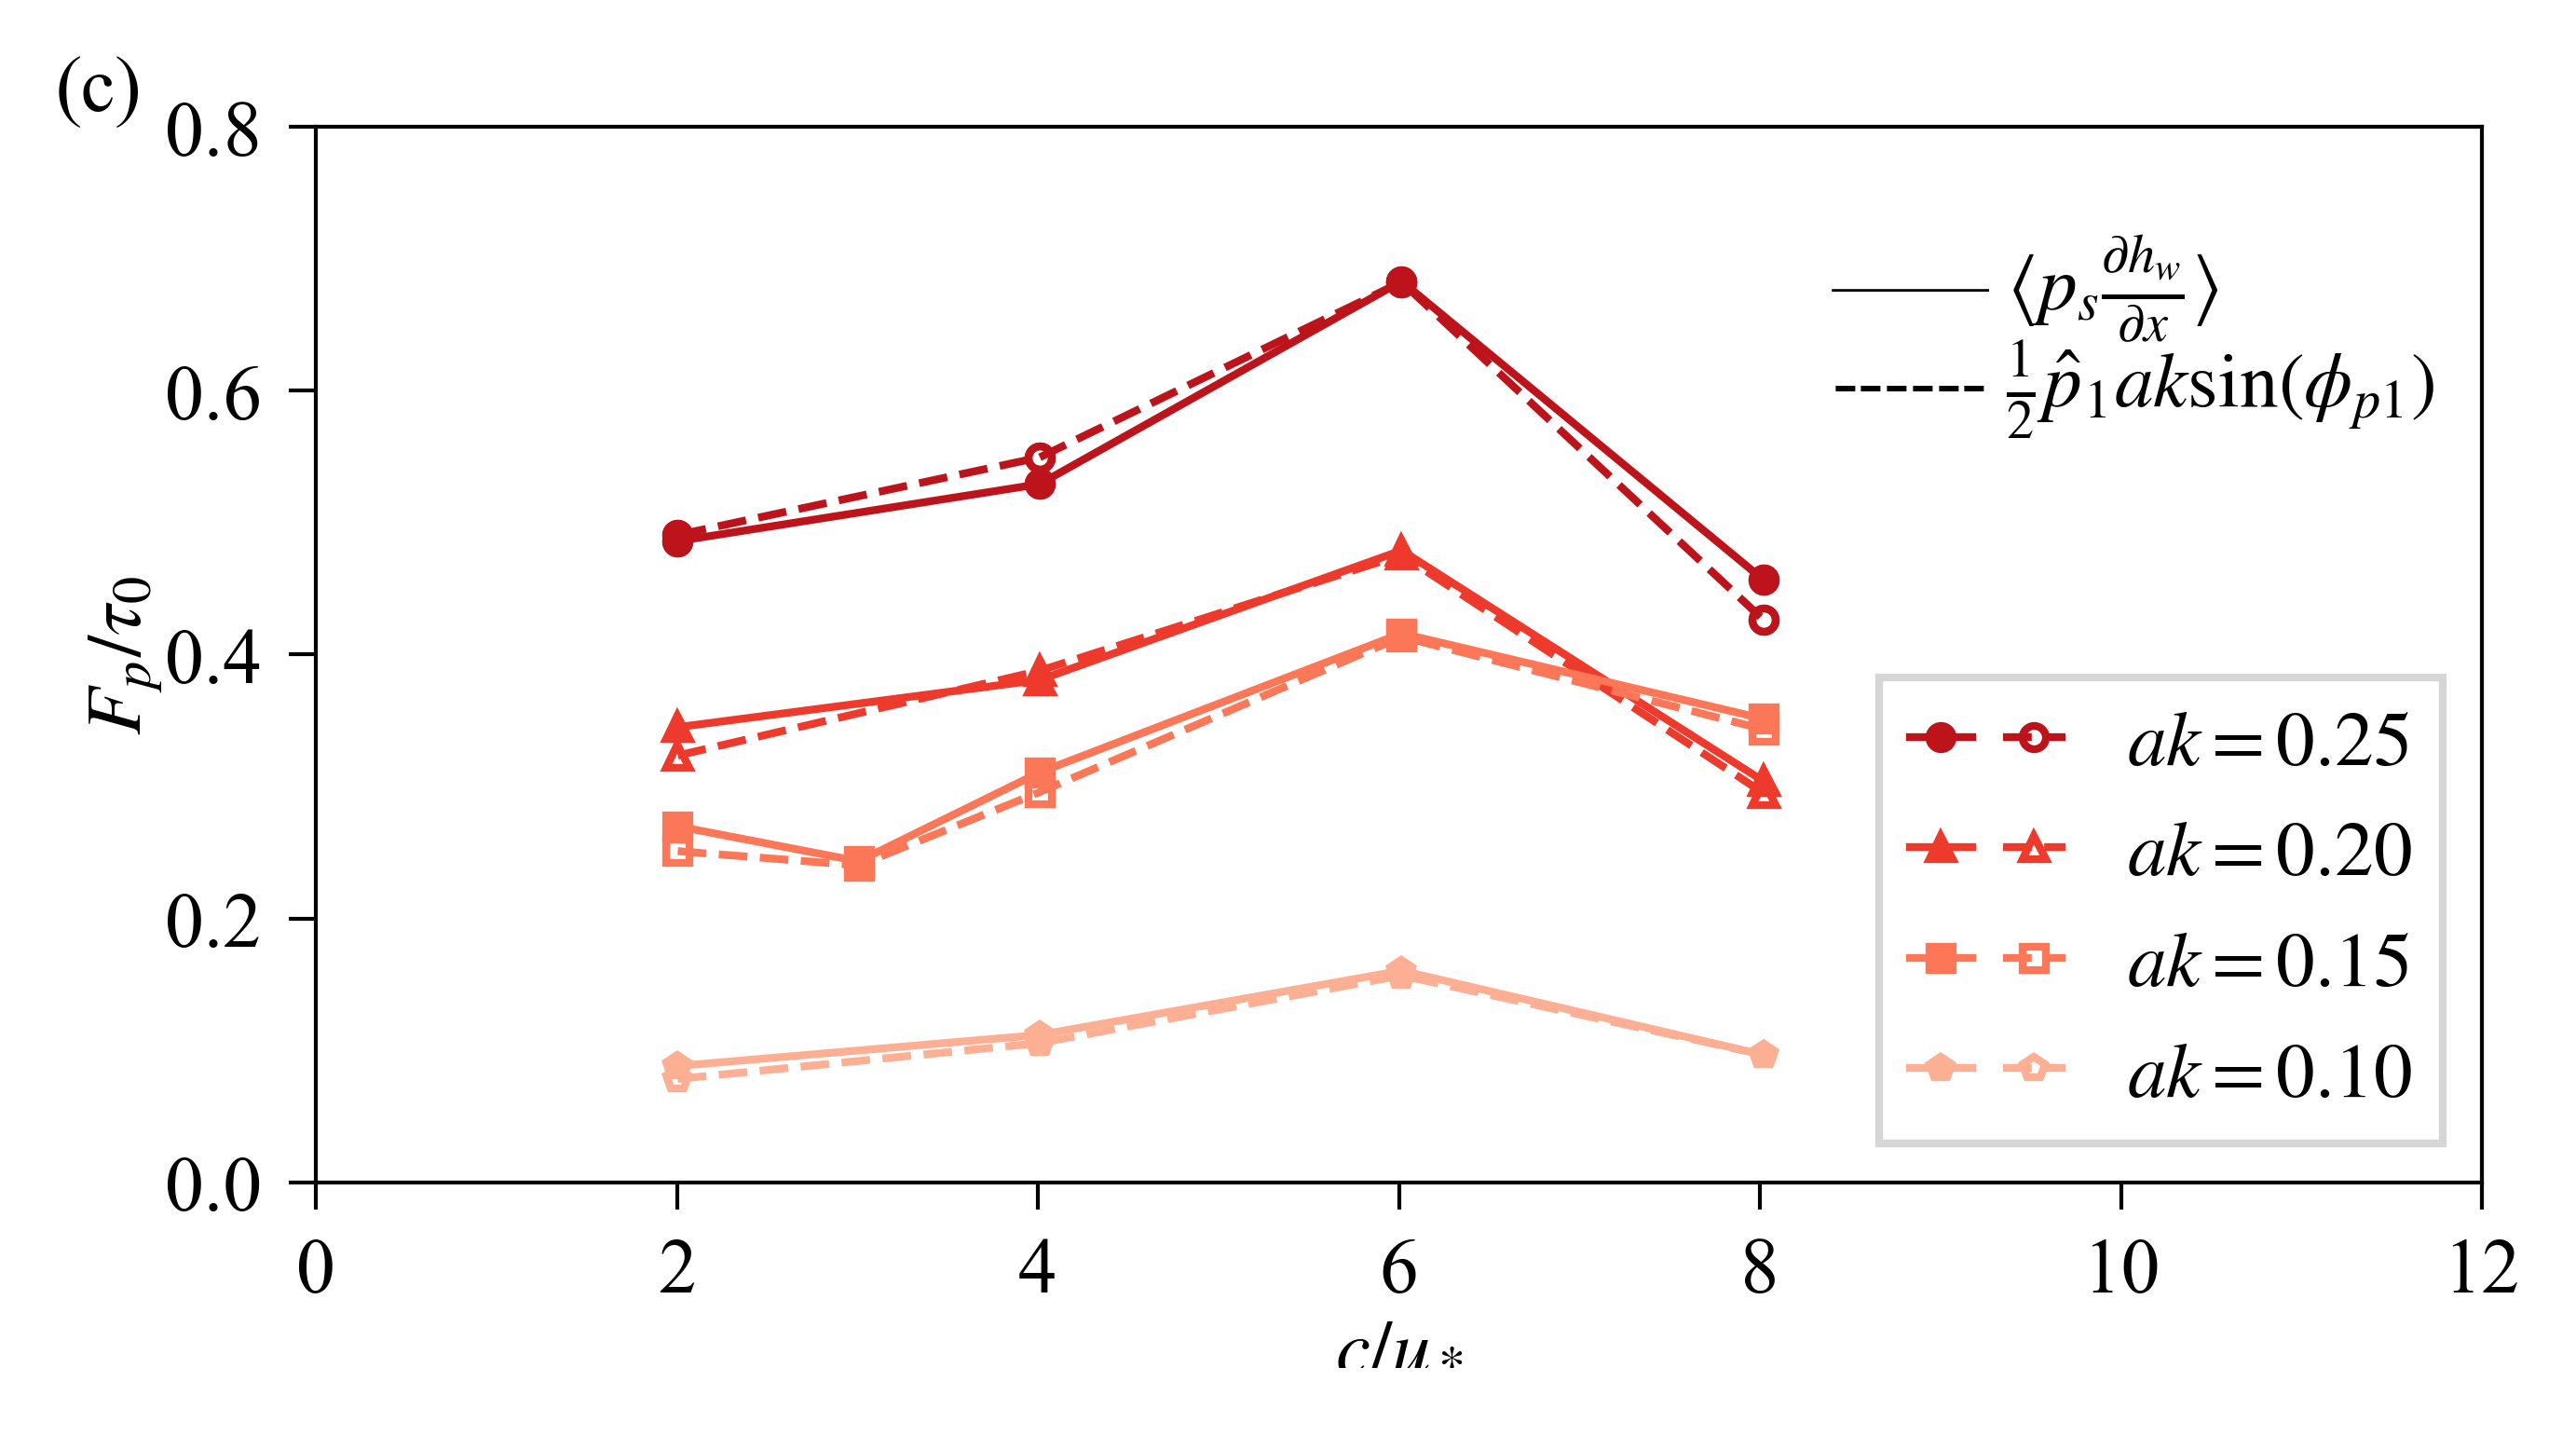

In [45]:
""" FIGURE: drag force as proportion of the total. """
fig = plt.figure(figsize=[5,2.5]); ax = plt.gca()

cu = []; Fp_aver = []; psin = []
for case in (case14,case15,case18,case16):
#     case.psin = 0.5*np.average(case.pamp)*np.sin(np.average(case.dphase)/128*2*np.pi)*case.ak
#     case.psin = case.cospectrum_fourier[0]*4
    case.psin = 0.5*case.pamp_spec[0]*np.sin(np.average(case.dphase_spec[0])/360*2*np.pi)*case.ak
    cu.append(case.wave.c/case.ustar); Fp_aver.append(case.Fp_aver/case.tau0); psin.append(case.psin/case.tau0)
    print(case.wave.c/case.ustar,case.Fp_aver/case.tau0,case.psin/case.tau0)
    cu.append(case.wave.c/case.ustar); Fp_aver.append(case.Fp_aver/case.tau0); psin.append(case.psin/case.tau0)
p1, = plt.plot(cu, Fp_aver, marker='o', fillstyle='full', markeredgewidth=1, lw=1, markersize=3, color=cmap(39), alpha = 1)
p2, = plt.plot(cu, psin, '--', marker='o', fillstyle='none', markeredgewidth=1, lw=1, markersize=3, color=cmap(39), alpha = 1)

cu = []; Fp_aver = []; psin = []
for case in (case1,case2,case19,case3):
#     case.psin = 0.5*np.average(case.pamp)*np.sin(np.average(case.dphase)/128*2*np.pi)*case.ak
#     case.psin = case.cospectrum_fourier[0]*4
    case.psin = 0.5*case.pamp_spec[0]*np.sin(np.average(case.dphase_spec[0])/360*2*np.pi)*case.ak
    cu.append(case.wave.c/case.ustar); Fp_aver.append(case.Fp_aver/case.tau0); psin.append(case.psin/case.tau0)
p3, = plt.plot(cu, Fp_aver, marker='^', fillstyle='full', markeredgewidth=1, lw=1, markersize=3, color=cmap(37), alpha = 1)
p4, = plt.plot(cu, psin, '--', marker='^', fillstyle='none', markeredgewidth=1, lw=1, markersize=3, color=cmap(37), alpha = 1)

cu = []; Fp_aver = []; psin = []
for case in (case7,case8,case9,case10,case11):
#     case.psin = 0.5*np.average(case.pamp)*np.sin(np.average(case.dphase)/128*2*np.pi)*case.ak
#     case.psin = case.cospectrum_fourier[0]*4
    case.psin = 0.5*case.pamp_spec[0]*np.sin(np.average(case.dphase_spec[0])/360*2*np.pi)*case.ak
    cu.append(case.wave.c/case.ustar); Fp_aver.append(case.Fp_aver/case.tau0); psin.append(case.psin/case.tau0)
p5, = plt.plot(cu, Fp_aver, marker='s', fillstyle='full', markeredgewidth=1, lw=1, markersize=3, color=cmap(35), alpha = 1)
p6, = plt.plot(cu, psin, '--', marker='s', fillstyle='none', markeredgewidth=1, lw=1, markersize=3, color=cmap(35), alpha = 1)

cu = []; Fp_aver = []; psin = []
for case in (case4,case5,case17,case6):
#     case.psin = 0.5*np.average(case.pamp)*np.sin(np.average(case.dphase)/128*2*np.pi)*case.ak
#     case.psin = case.cospectrum_fourier[0]*4
    case.psin = 0.5*case.pamp_spec[0]*np.sin(np.average(case.dphase_spec[0])/360*2*np.pi)*case.ak
    cu.append(case.wave.c/case.ustar); Fp_aver.append(case.Fp_aver/case.tau0); psin.append(case.psin/case.tau0)
p7, = plt.plot(cu, Fp_aver, marker='p', fillstyle='full', markeredgewidth=1, lw=1, markersize=3, color=cmap(33), alpha = 1)
p8, = plt.plot(cu, psin, '--', marker='p', fillstyle='none', markeredgewidth=1, lw=1, markersize=3, color=cmap(33), alpha = 1)


l = ax.legend([(p1, p2),(p3, p4),(p5, p6), (p7,p8)], [r'$ak=0.25$',r'$ak=0.20$',r'$ak=0.15$',r'$ak=0.10$'],
               handler_map={tuple: HandlerTuple(ndivide=None)}, loc='lower right', fancybox=False, handlelength=2)
ax.annotate(r'—— $\langle p_s \frac{\partial h_w}{\partial x} \rangle$', xy=(0.7, 0.9), ha='left', va='top', xycoords='axes fraction')
ax.annotate(r'------ $\frac{1}{2}\hat{p}_1 ak \sin(\phi_{p1})$', xy=(0.7, 0.8), ha='left', va='top', xycoords='axes fraction')
ax.annotate('(c)', xy=(-0.12, 1), ha='left', va='bottom', xycoords='axes fraction')

plt.xlabel(r'$c/u_*$', labelpad=0)
plt.ylim([0,0.8])
plt.xlim([0,12])
plt.ylabel(r'$F_p/\tau_0$', labelpad=0)
# fig.savefig('figures/drag_coefficient_check.pdf', bbox_inches='tight', pad_inches=0.1)
# fig.savefig('figures_jfm/drag_coefficient_waveage.pdf', bbox_inches='tight')
# fig.savefig('figures_jfm/drag_coefficient_waveage.eps', bbox_inches='tight')
fig.savefig('review/drag_coefficient_waveage.pdf', bbox_inches='tight')
fig.savefig('review/drag_coefficient_waveage.eps', bbox_inches='tight')

0.27032734424858607
0.2546923217849233
0.25078854967871167
0.24400119123447217


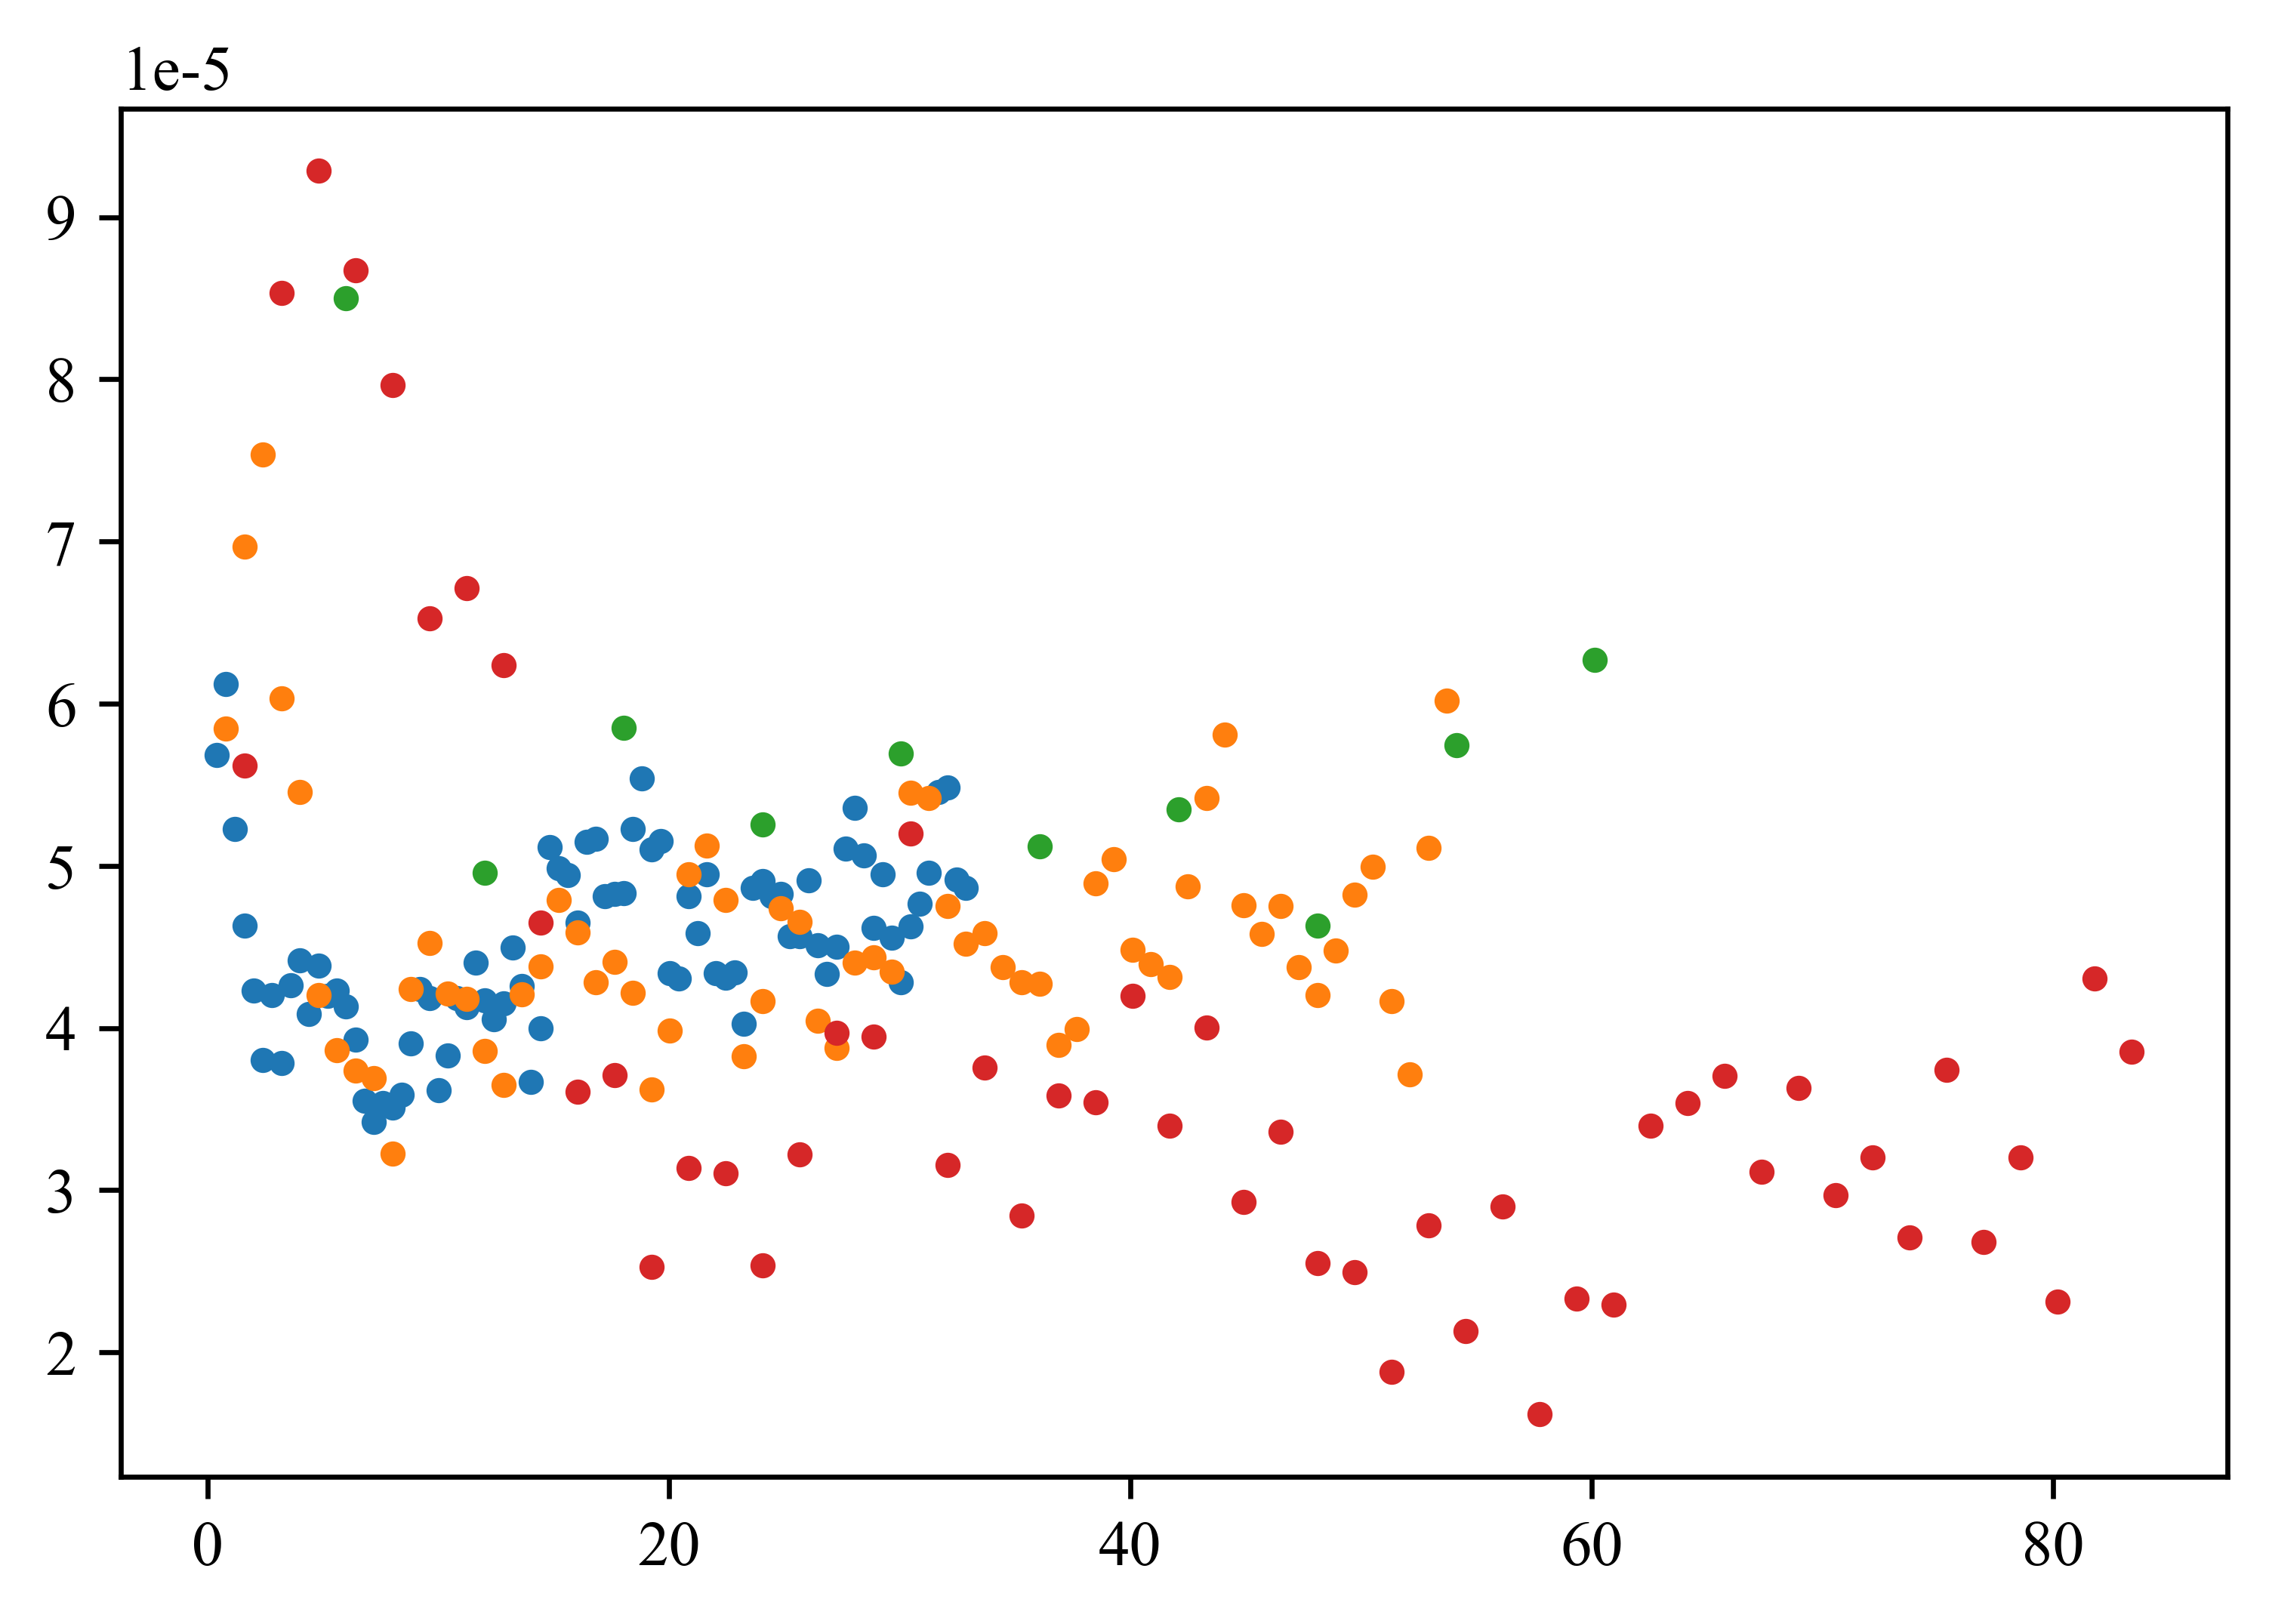

In [70]:
""" CHECK: which part of the Fp to keep. """
# for case in (case1,case2,case3):
# # for case in (case4,case5,case6):
#     eta = np.average(case.phase['eta'][-1], axis=0) - np.average(case.phase['eta'][-1], axis=(0,1))
#     print((np.average(eta**2)*2)**0.5*4)
#     plt.plot(np.array(case.p['t'])*case.wave.omega, case.Fp, '.')
for case in (case14,case15,case18,case16):
# for case in (case4,case5,case6):
    eta = np.average(case.phase['eta'][-1], axis=0) - np.average(case.phase['eta'][-1], axis=(0,1))
    print((np.average(eta**2)*2)**0.5*4)
    plt.plot(np.array(case.p['t'])*case.wave.omega, case.Fp, '.')

0.17645208267482598
0.15890439214588753
0.1494488386404838


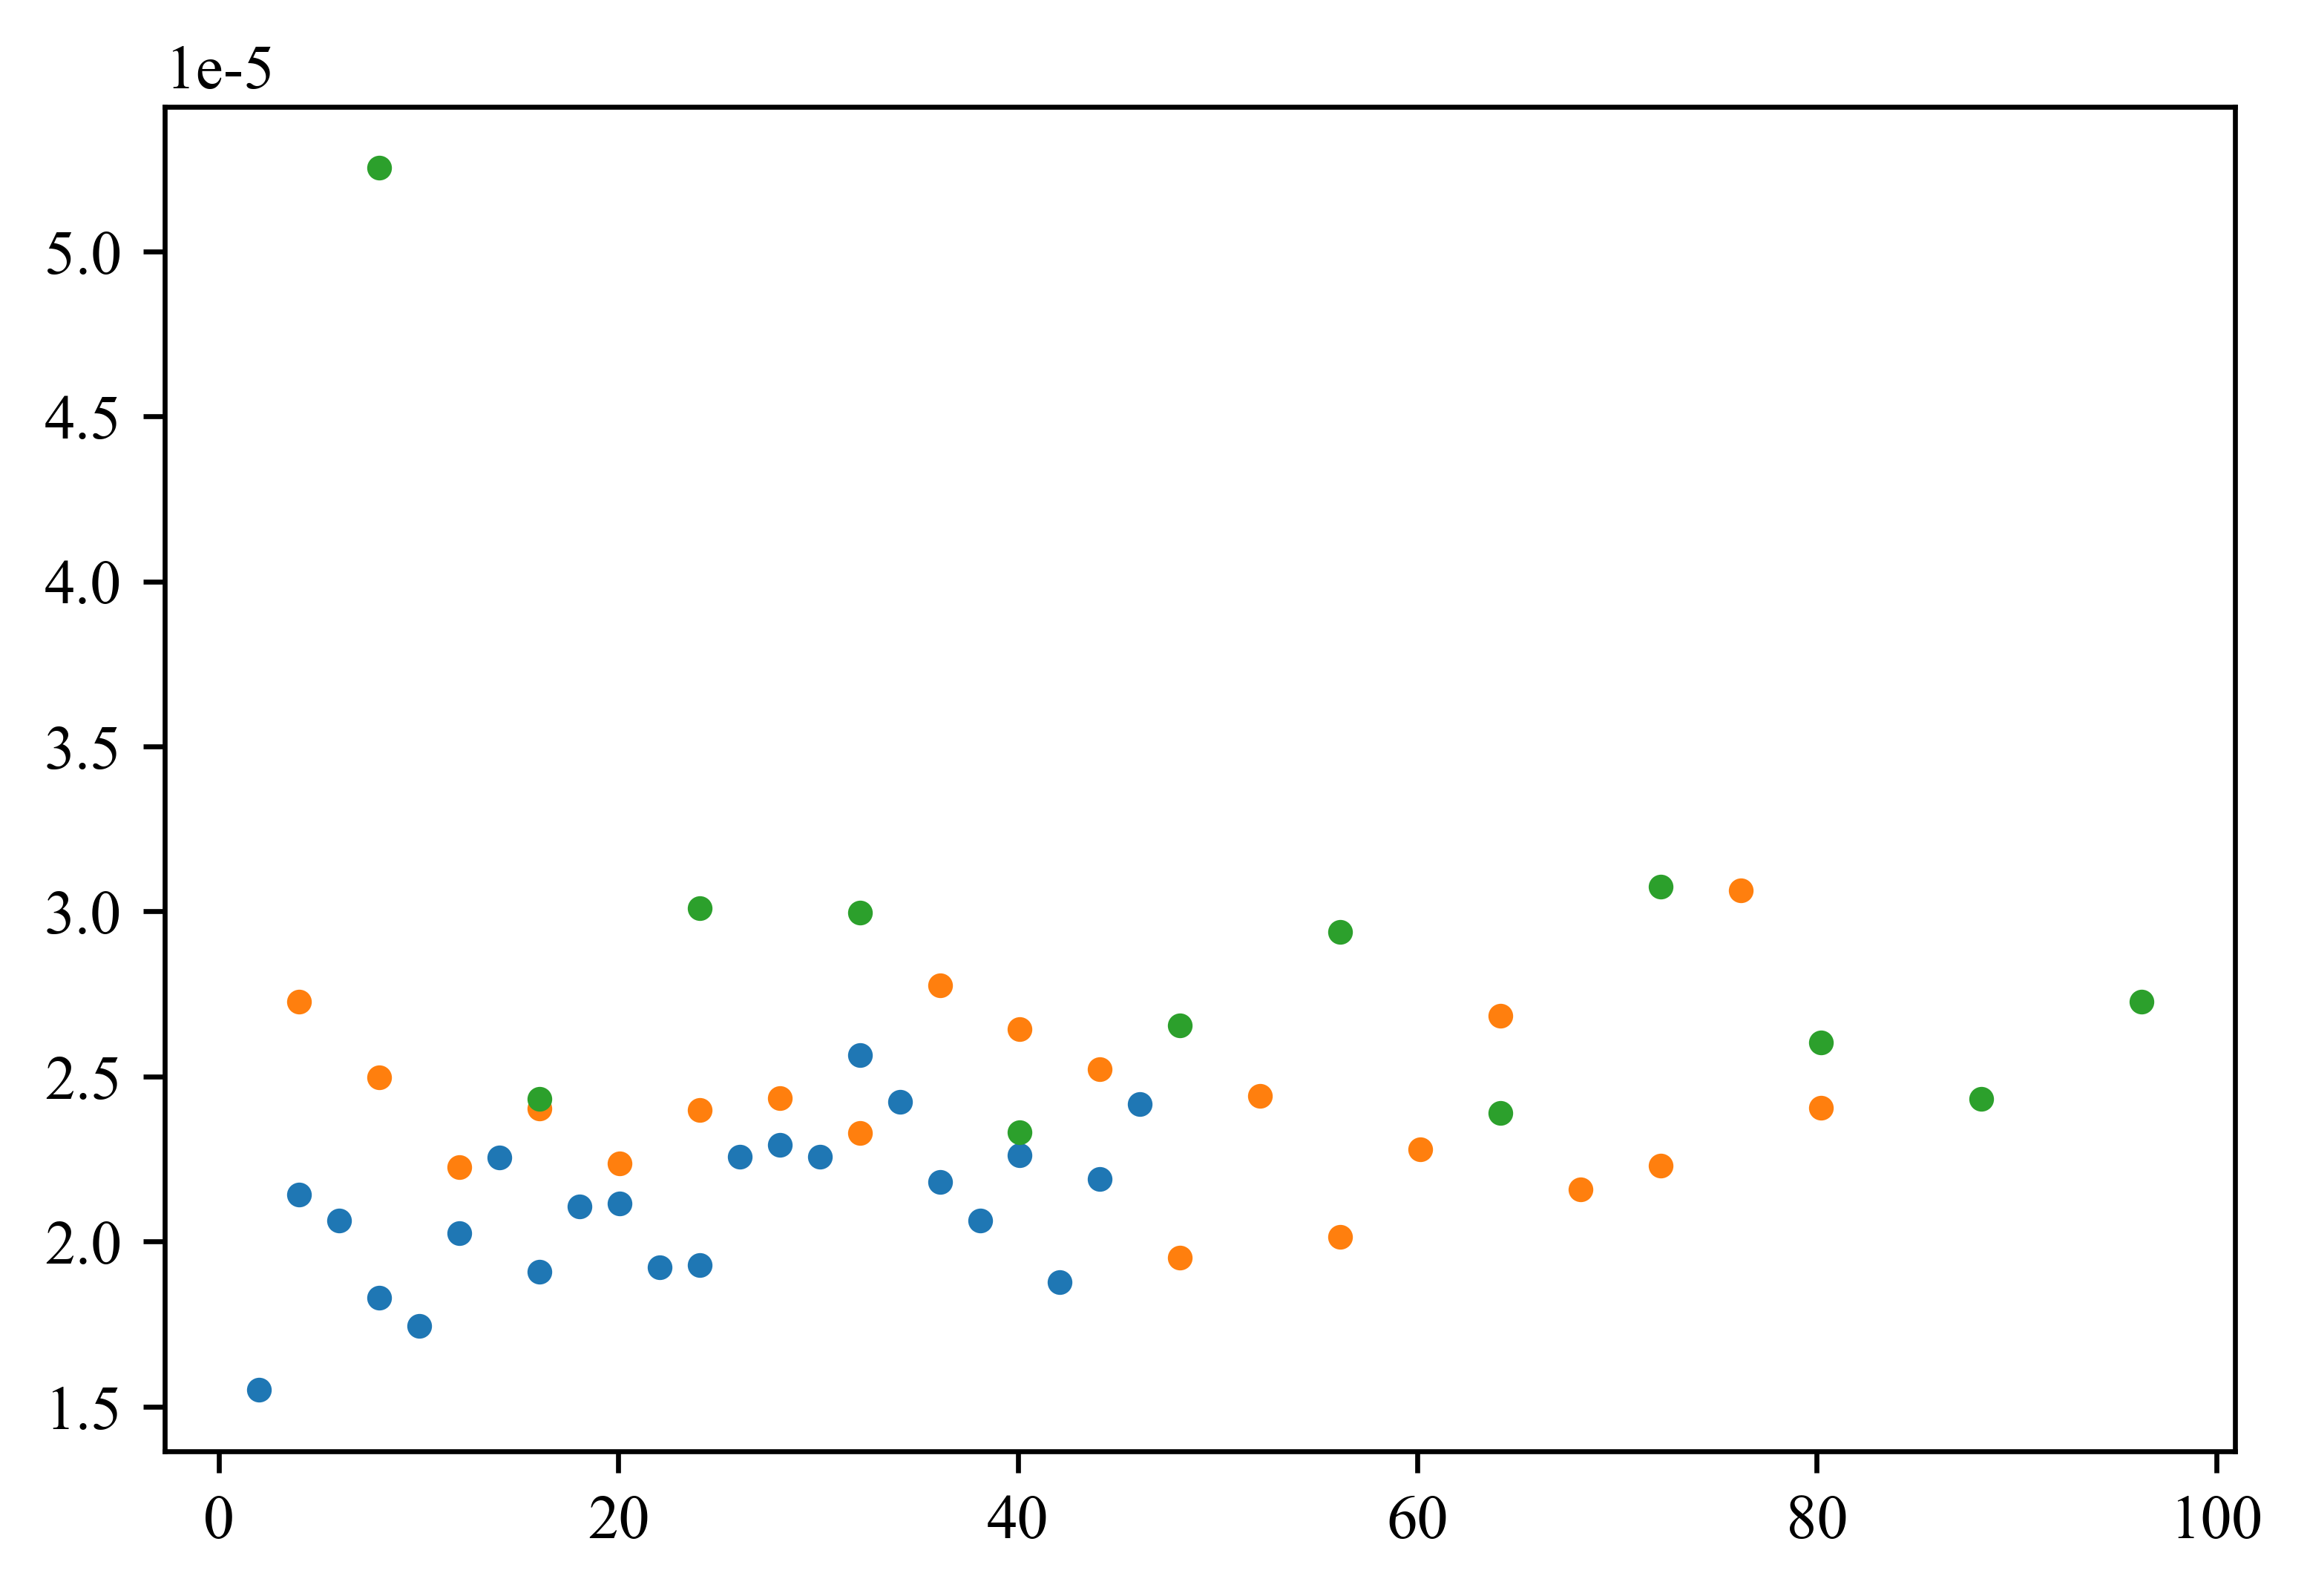

In [428]:
""" CHECK: which part of the Fp to keep. """
for case in (case7,case9,case11):
    eta = np.average(case.phase['eta'][-1], axis=0) - np.average(case.phase['eta'][-1], axis=(0,1))
    print((np.average(eta**2)*2)**0.5*4)
    plt.plot(np.array(case.p['t'])*case.wave.omega, case.Fp, '.')

In [ ]:
""" Reference:
    numpy/scipy correlation function: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate.html
    scipy csd: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.csd.html
"""

In [310]:
case = case1
p2D = np.average(case.p_2D, axis=0)
eta = np.roll(np.average(case.phase['eta'][-1], axis=0), -case.phase['idx'][-1], axis=0) - 1 # Last frame of eta
p2D_sample, zsample = sampling(p2D, case=case, hsample=0.02*2*np.pi/case.k, eta=eta)
# p2D_interp, zgrid = array_newcoord(p2D, case=case, eta=eta)
# f1, Pxy1 = signal.csd(eta, p2D_interp[:,85]-np.average(p2D_interp[:,85]), fs=512/4, nperseg=32)
f3, Pxy3 = signal.csd(eta, p2D_sample-np.average(p2D_sample), fs=512, nperseg=512, window='hanning', scaling='spectrum') 
print(Pxy3[4].imag*4/case.tau0)
# f3, Pxy3 = signal.csd(eta, p2D_sample-np.average(p2D_sample), fs=512, nperseg=32, scaling='spectrum') 
# print(np.abs(Pxy3[1]))

0.597677228408425


In [291]:
# How does the correlate function deal with padding?
corr = np.correlate(p2D_sample-np.average(p2D_sample), 4*eta[::-1], 'same')/512
print(corr[128+96]/case.tau0)
print(np.average(case.Fp)/case.tau0)
# corr = signal.correlate(p2D_sample-np.average(p2D_sample), eta[::-1], mode='same') / 512
# print(cov()*512/case.tau0)

0.5823873203024165
0.5156898370663913


(512,)


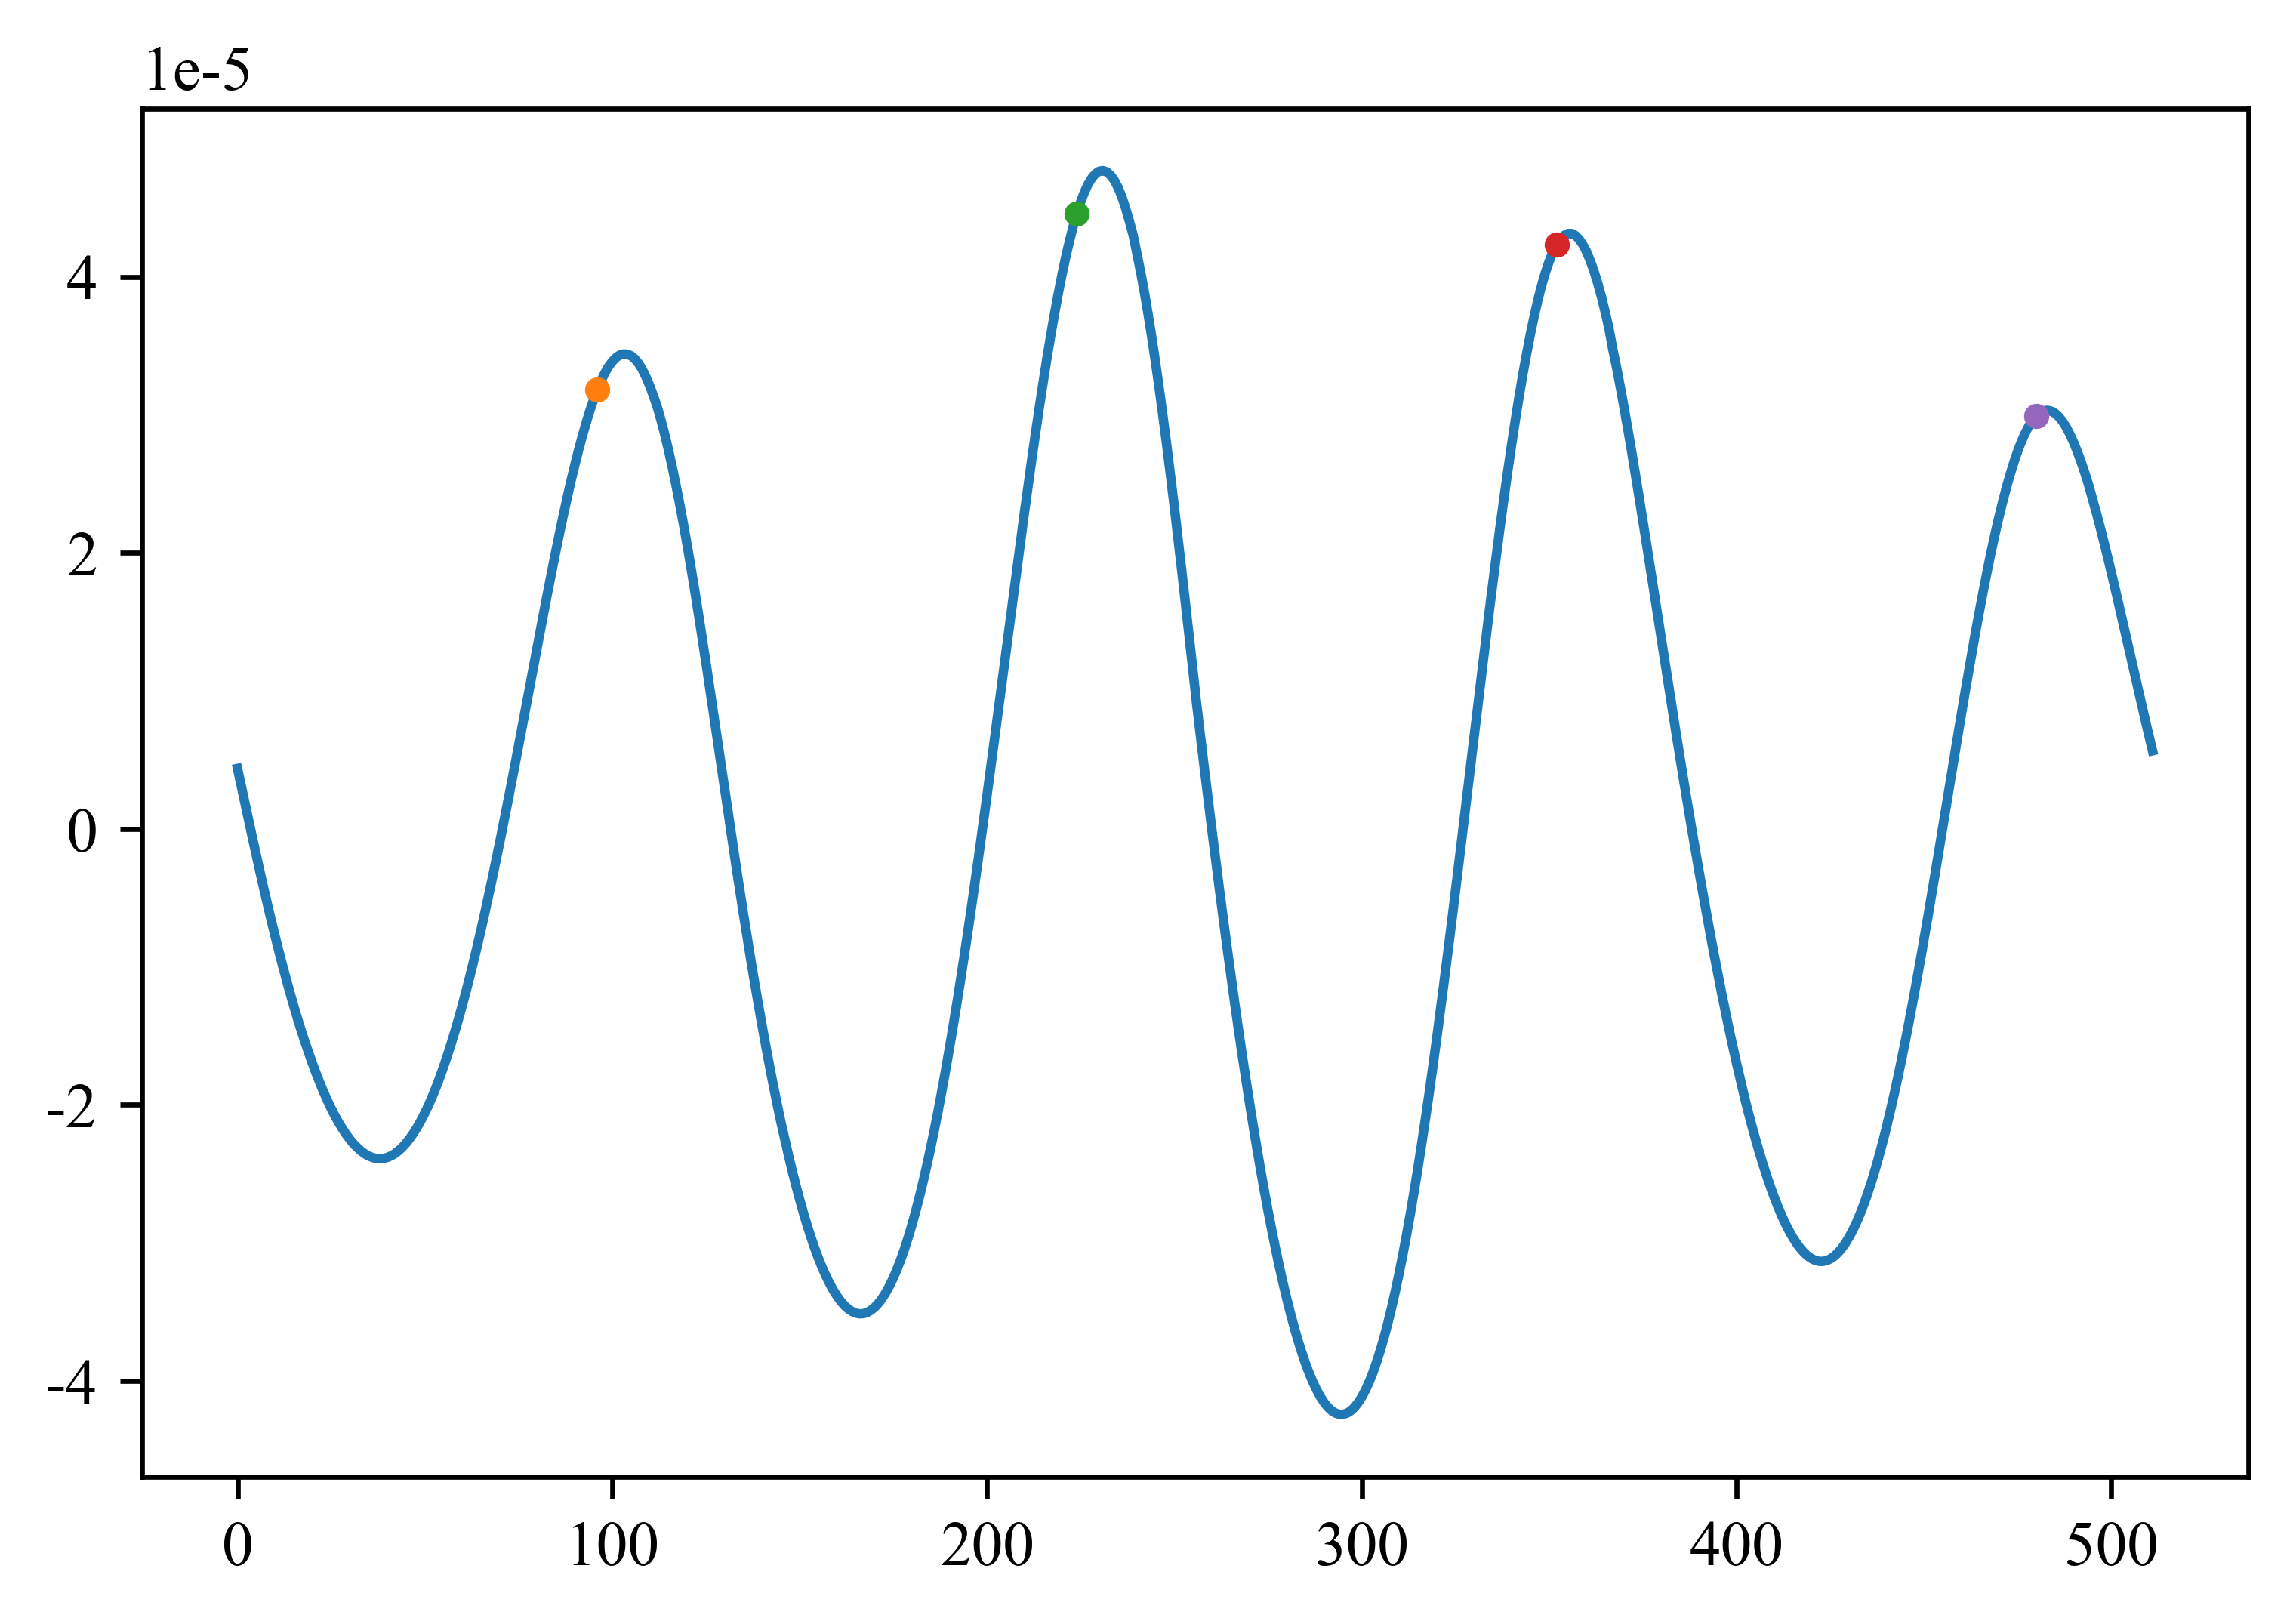

In [292]:
print(corr.shape)
plt.plot(corr)
plt.plot(96, corr[96], '.')
plt.plot(128+96, corr[128+96], '.')
plt.plot(256+96, corr[256+96], '.')
plt.plot(384+96, corr[384+96], '.')

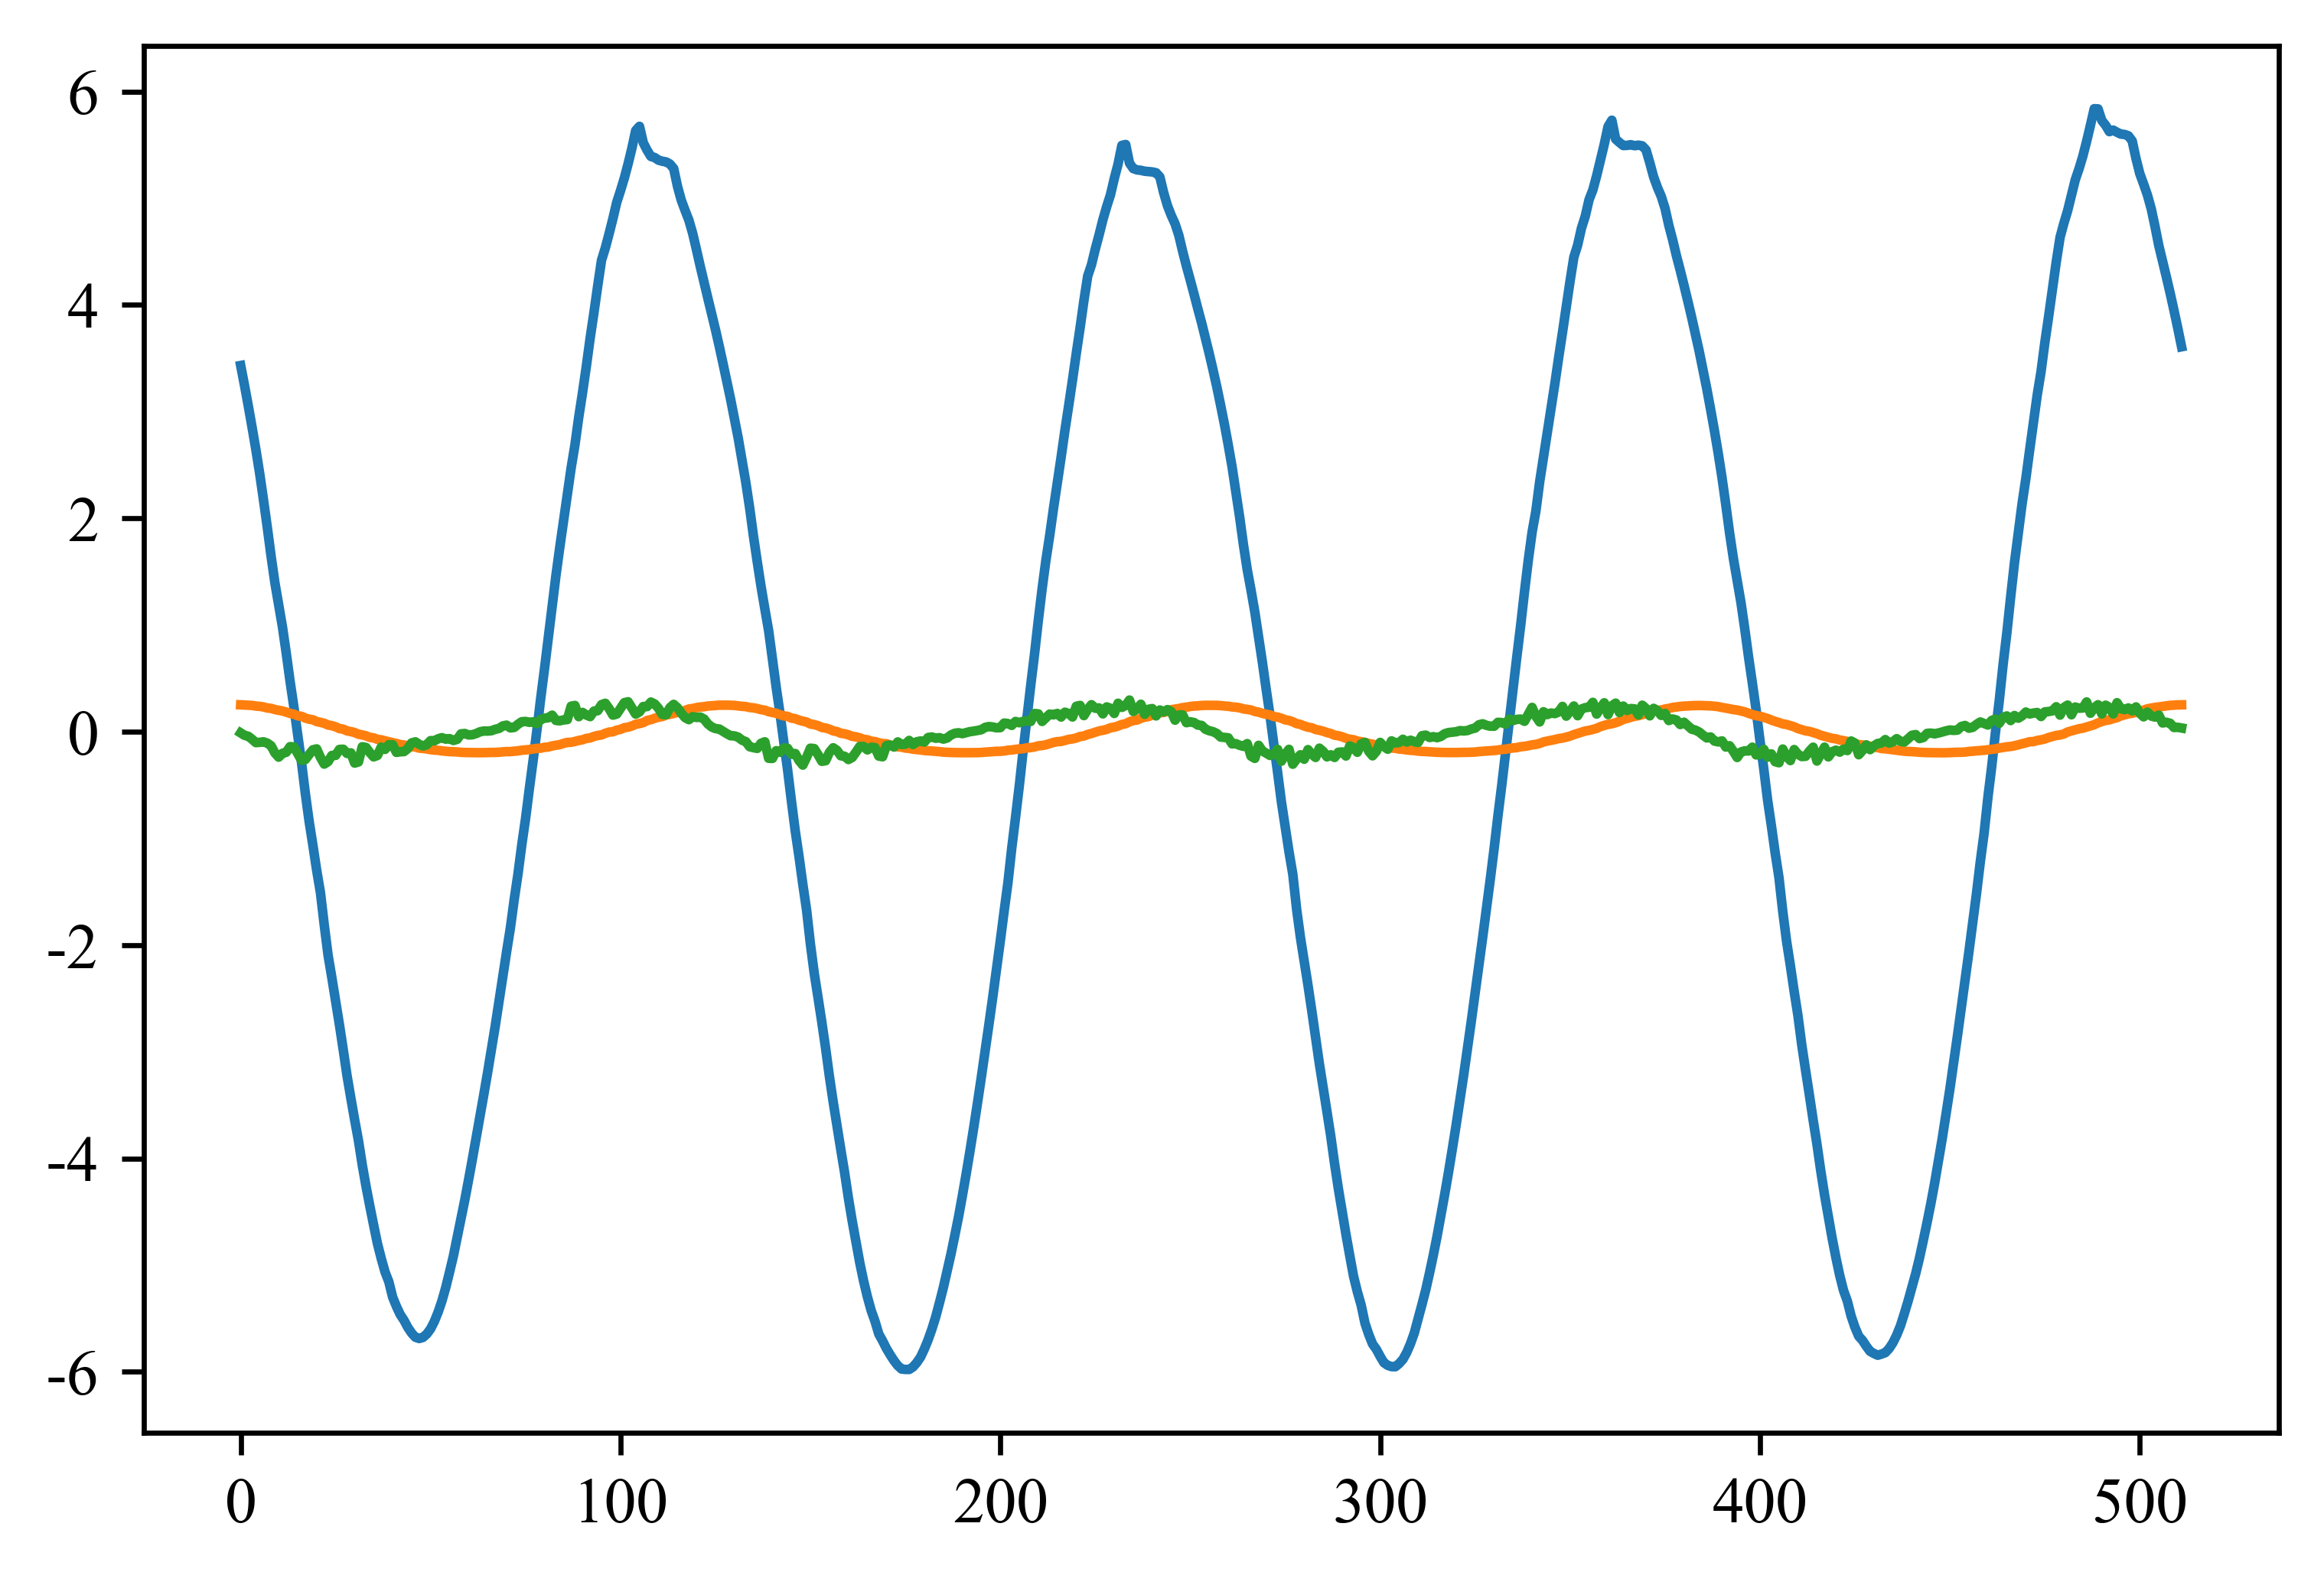

In [265]:
plt.plot((p2D_sample-np.average(p2D_sample))/case.tau0)
grad = np.gradient(eta)/(2*np.pi/512)  
plt.plot(eta[::-1]*4)
plt.plot(grad)